# Sample of plots for converted umnsaa_pc20060515

Cartopy packages for map plotting

Matplotlib packages for other plotting

Add some plotting config and the locations of data files here

In [6]:
# Show plots in the browser
%matplotlib inline

import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
# mapping libraries
import cartopy
import cartopy.feature as cpf
# geometry to add onto cartopy
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.transforms import offset_copy

# Plot defaults
mpl.rcParams['font.size'] = 18.0
mpl.rcParams["text.usetex"]      = False     #
mpl.rcParams["legend.numpoints"] = 1         # one point for marker legends
mpl.rcParams["figure.figsize"]   = (12, 10)  #
mpl.rcParams["font.size"]        = 18        # font sizes:
mpl.rcParams["axes.titlesize"]   = 26        # title font size
mpl.rcParams["axes.labelsize"]   = 20        #
mpl.rcParams["xtick.labelsize"]  = 16        #
mpl.rcParams["ytick.labelsize"]  = 16        #
mpl.rcParams['image.cmap'] = 'plasma' #'PuRd' #'inferno_r'       # Colormap default
mpl.rcParams['axes.formatter.useoffset'] = False

# Data file locations
pafile = 'data/umnsaa_pa2016010515.nc'
pcfile = 'data/umnsaa_pc2016010515.nc'

# Map boundaries for waroona
# Extents: EWSN
extents = {}
extents['waroona'] = [115.5,116.3, -33.1,-32.5]
extents['waroonas'] = [109,125,-37,-29] # synoptic
latlons = {}
latlons['waroona'] = -32.8430, 115.8526 # latlon of waroona

# Projection used in cartopy
proj = cartopy.crs.PlateCarree()

# high resolution map features can be used
zoomedland = cartopy.feature.NaturalEarthFeature(category='physical',
                                                 name='land',
                                                 scale='10m',
                                                 facecolor="none")
zoomedcoast = cartopy.feature.NaturalEarthFeature(category='physical',
                                                  name='coastline',
                                                  scale='10m')
states= cartopy.feature.NaturalEarthFeature(
          category='cultural',
          name='admin_1_states_provinces_lines',
          scale='50m',
          facecolor='none')

##### Show the map of Waroona

inset the synoptic map for context

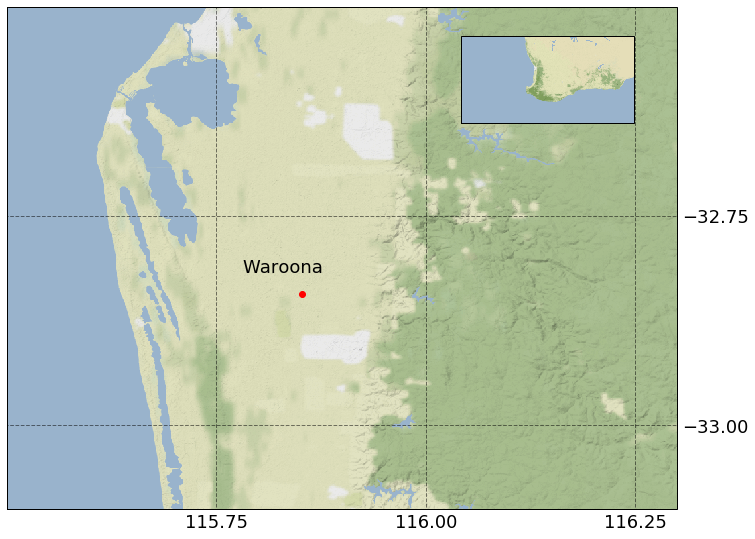

In [23]:



plt.close()
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure()
# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=proj)#stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 14.
ax.add_image(stamen_terrain, 11)

# Grid lines and labels
gl = ax.gridlines(crs=proj, linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right=True
gl.xlines = True
gl.xlocator = mpl.ticker.FixedLocator(np.arange(110,120,0.25))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(-40,-10,0.25))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


# Add a marker for waroona volcano. LON, LAT, ... argument order important!
plt.plot(latlons['waroona'][1], latlons['waroona'][0],
         color='red', linewidth=0, marker='o',
         transform=proj)
dx,dy = 0.025,0.025
plt.text(latlons['waroona'][1]+dx, latlons['waroona'][0]+dy, 'Waroona',
         horizontalalignment='right',
         transform=proj)

# Show synoptic area for reference
sub_ax = plt.axes([0.65, 0.65, 0.2, 0.2], projection=proj)
sub_ax.set_extent(extents['waroonas'], crs=proj)
# Add the land, coastlines.
#sub_ax.add_feature(zoomedland)
# Add the Stamen data.
sub_ax.add_image(stamen_terrain, 7)
sub_ax.add_feature(states,zorder=2)
#sub_ax.add_feature(zoomedcoast)
# sgeom boxes based on ESWN?
drawbox=extents['waroona']
extent_box = sgeom.box(drawbox[0], drawbox[2], drawbox[1], drawbox[3])
sub_ax.add_geometries([extent_box], proj, color='none',
                          edgecolor='blue', linewidth=2, zorder=3)

plt.show()

## Load data

read dataset and keep some variables

In [5]:
with Dataset(pcfile,'r') as ncfile:
    
    ## PULL OUT MASKED ARRAYS
    #zth  = ncfile.variables['height_theta'][0,:,::-1,:] # flip latitudes for interpolate
    #zrho = ncfile.variables['height_rho'  ][0,:,::-1,:]
    lat  = ncfile.variables['latitude'   ][:]
    lon  = ncfile.variables['longitude'  ][:]
    lat1 = ncfile.variables['latitude_0' ][:] # Edges??
    lon1 = ncfile.variables['longitude_0'][:] # Edges??
    z   = ncfile.variables['model_level_number'  ][:]
    z1  = ncfile.variables['model_level_number_0'][:]
    Ta  = ncfile.variables['air_temperature'][:,:] # at surface? only stored at surface?
    p   = ncfile.variables['air_pressure'][0,0:70,:,:] # in pascals
    pmsl = ncfile.variables['air_pressure_at_sea_level'][0,:,:]
    u1  = ncfile.variables['x_wind'][0,0:70,:,:] # wind speeds are on their directional grid edges (z,lats,lon1)
    v1  = ncfile.variables['y_wind'][0,0:70,:,:] # [z,lat1,lons]
    q   = ncfile.variables['specific_humidity_0'][0,0:70,:,:]
    #w   = ncfile.variables['upward_air_velocity'][0,0:70,:,:]
    #qc  = ncfile.variables['mass_fraction_of_cloud_liquid_water_in_air'][0,0:70,:,:] + ncfile.variables['mass_fraction_of_cloud_ice_in_air'][0,0:70,:,:]


## Destagger winds
#u = np.tile(np.nan,(nz,ny,nx))
u = np.tile(np.nan,(nz,ny,nx)) # tile repeats the nan accross nz,ny,nx dimensions
u[:,:,1:] = 0.5*(u1[:,:,1:] + u1[:,:,:-1]) # interpolation of edges
v = 0.5*(v1[:,1::,] + v1[:,:-1,:]) # interpolation of edges
s = np.hypot(u,v) # Speed is hypotenuse of u and v
lonu = lon1
latu = lat
lonv = lon
latv = lat1
    
#nz,ny,nx = Ta.shape
nz,ny,nx = p.shape

# dummy topog for now
topog = np.zeros([len(lat),len(lon)])
latt,lont = lat,lon
# READ TOPOG DATA FROM PA
with Dataset(pafile,'r') as ncfile:
    topog = ncfile.variables['surface_altitude'][:,:]
    latt = ncfile.variables['latitude' ][:]
    lont = ncfile.variables['longitude'][:]

## Plot winds at surface and high troposphere

Quiver for horizontal winds, contour to show vertical windspeed

Add coastlines to map for context

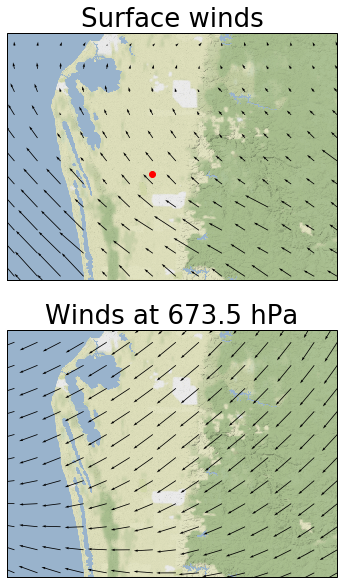

In [22]:
plt.close()

# Reduce resolution by skipping n-1 datapoints in every n
skiplen = 20
skip=(slice(None,None,skiplen),slice(None,None,skiplen))
latlr = lat[::skiplen]
lonlr = lon[::skiplen]
usurflr = u[0][skip]
vsurflr = v[0][skip]
zlev=65
uhighlr = u[zlev][skip] # higher altitude winds
vhighlr = v[zlev][skip]
arrowscale=70 # smaller number makes arrows huge in quiver plot

fig = plt.figure()
# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(2, 1, 1, projection=proj)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 11.
ax.add_image(stamen_terrain, 11)


# Add a marker for waroona volcano. LON, LAT, ... argument order important!
plt.plot(latlons['waroona'][1], latlons['waroona'][0],
         color='red', linewidth=0, marker='o',
         transform=proj)

# PLOT THE QUIVER WITH WINDS
plt.title("Surface winds")
# Add arrows to show the wind vectors
plt.quiver(lonlr, latlr, usurflr, vsurflr, zorder=2,color='k', scale=arrowscale)


# Plot high winds too
ax2 = fig.add_subplot(2, 1, 2, projection=proj)

# Limit the extent of the map to a small longitude/latitude range.
ax2.set_extent(extents['waroona'], crs=proj)

# Add the Stamen data at zoom level 14.
ax2.add_image(stamen_terrain, 11)

# quiver at higher altitude
plt.title("Winds at %.1f hPa"%np.nanmean(p[zlev]/100.))
plt.quiver(lonlr, latlr, uhighlr, vhighlr, zorder=2,color='k',scale = arrowscale)


plt.show()

## Cross section looking at vertical winds

pull out and plot cross section of winds and also show topography